# Assignment 2 - Building CNNs

**ASSIGNMENT DEADLINE: 19 OCT 2017 (THU) 11.59PM**

In this assignment we will be coding the building blocks for the convolutional neural network and putting them together to train a CNN on the CIFAR2 dataset (taking just 2 classes (airplane and bird) from the original 10 classes).

***Please note that we have changed to using just 2 classes (airplane and bird) from the original CIFAR10 dataset. get_cifar2_data code in data_utils.py will load the 2-class data accordingly.***

We would like to credit the Stanford CS231n team as much of our code backbone is from their Assignment 2. The teaching team at Stanford has kindly agreed for us to adapt their assignment and code. You will find that we adopt a modular design of the code. You will implement different layer types in isolation and then combine them together into models with different architectures.

For each layer we will implement a forward and a backward function. The forward function will receive inputs, weights, and other parameters and will return both an output and a cache object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the cache object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.


# Submission details
Since we have not restricted the usage of other programming languages, our submission format will need to be in output text form (similar to the previous assignment). For each question, we will provide the input arguments and you have to provide a text file containing the corresponding output, to a certain precision.

This iPython notebook serves to:
- explain the questions
- explain the function APIs
- providing helper functions to piece functions together and check your code 
- providing helper functions to load and save arrays as csv files for submission

Hence, we strongly encourage you to use Python for this assignment as you will only need to code the relevant parts and it will reduce your workload significantly. For non-Python users, some of the cells here are for illustration purpose, you do not have to replicate the demos.

The input files will be in the `input_files` folder, and your output files should go into `output_files` folder. Similar to assignment 1, use np.float32 if you are using Python and use **at least 16 significant figures** for your outputs. For Python users, if you use the accompanying printing functions when using np.float32 variables, you should be ok.

In [2]:
# A bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from code_base.classifiers.cnn import *
from code_base.data_utils import get_CIFAR2_data
from code_base.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from code_base.layers import *
from code_base.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR2 (airplane and bird) data.

data = get_CIFAR2_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

y_test:  (2000,)
X_test:  (2000, 3, 32, 32)
X_train:  (9800, 3, 32, 32)
y_train:  (9800,)
X_val:  (200, 3, 32, 32)
y_val:  (200,)


# Convolution: Forward pass
In the file `code_base/layers.py`, implement the forward pass for a convolutional layer in the function `conv_forward`.

The input consists of N data points, each with C channels, height H and width W. We convolve each input with F different filters, where each filter spans all C channels and has height HH and width HH.

Input:
- x: Input data of shape (N, C, H, W)

- w: Filter weights of shape (F, C, HH, WW)

- b: Biases, of shape (F,)

`conv_param` contains the stride and padding width:

- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.

- 'pad': The number of pixels that will be used to zero-pad the input in each x-y direction. We will use the same definition in lecture notes 3b, slide 13 (ie. same padding on both sides). Hence `p=2` means a 1-pixel border of padding with zeros.

**WARNING:** Please implement the matrix product method of convolution as shown in Lecture notes 4, slide 38. The naive version of implementing a sliding window will be too slow when you try to train the whole CNN in later sections.

You can test your implementation by running the following:

In [ ]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 2}
out, _ = conv_forward(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward')
print('difference: ', rel_error(out, correct_out))

**FOR SUBMISSION:** Submit the corresponding output from your foward convolution for the given input arguments. Load the files `conv_forward_in_x.csv`, `conv_forward_in_w.csv` and `conv_forward_in_b.csv`, they contain the input arguments for the `x`, `w` and `b` respectively and are flattened to a 1D array in C-style, row-major order (see numpy.ravel for details: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html). 

For Python users, you can use the code below to load and reshape the arrays to feed into your `conv_forward` function. Code is also provided to flatten the array and save your output to a csv file. For users of other programming languages, you have to submit the output file `conv_forward_out.csv` which contains the flattened output of `conv_forward`. The array must be flattened in row-major order or else our automated scripts will mark your outputs as incorrect.

In [ ]:
x_shape = (2, 3, 6, 6)
w_shape = (3, 3, 4, 4)
x = np.loadtxt('./input_files/conv_forward_in_x.csv', delimiter=',')
x = x.reshape(x_shape)
w = np.loadtxt('./input_files/conv_forward_in_w.csv', delimiter=',')
w = w.reshape(w_shape)
b = np.loadtxt('./input_files/conv_forward_in_b.csv', delimiter=',')

conv_param = {'stride': 2, 'pad': 2}
out, _ = conv_forward(x, w, b, conv_param)
np.savetxt('./output_files/conv_forward_out.csv', out.ravel(), delimiter=',')

# Aside: Image processing via convolutions

In slide 32 of lecture 4, we mentioned that convolutions are able to perform low-level image processing such as edge detection. Here, we manually set up filters that perform common image processing operations (grayscale conversion and edge detection) and test them on two images. If your forward convolution pass works correctly, the visualization should make sense.

In [ ]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward(x, w, b, {'stride': 1, 'pad': 2})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Convolution: Backward pass
Implement the backward pass for the convolution operation in the function `conv_backward` in the file `code_base/layers.py`. 

When you are done, run the following to check your backward pass with a numeric gradient check. 

In gradient checking, to get an approximate gradient for a parameter, we vary that parameter by a small amount (while keeping rest of parameters constant) and note the difference in the network loss. Dividing the difference in network loss by the amount we varied the parameter gives us an approximation for the gradient. We repeat this process for all the other parameters to obtain our numerical gradient. Note that gradient checking is a slow process (2 forward propagations per parameter) and should only be used to check your backpropagation!

More links on gradient checking:

http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/

https://www.coursera.org/learn/machine-learning/lecture/Y3s6r/gradient-checking

**FOR SUBMISSION:** Submit the corresponding output from your backward convolution for the given input arguments. Load the files `conv_backward_in_x.csv`, `conv_backward_in_w.csv`, `conv_backward_in_b.csv` and `conv_backward_in_dout.csv`, they contain the input arguments for the `dx`, `dw`, `db` and `dout` respectively and are flattened to a 1D array in C-style, row-major order.

The input arguments have the following dimensions:
- x: Input data of shape (N, C, H, W)
- w: Filter weights of shape (F, C, HH, WW)
- b: Biases, of shape (F,)
- dout: Upstream derivatives.

`conv_param` contains the stride and padding width:

- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.

- 'pad': The number of pixels that will be used to zero-pad the input in each x-y direction. We will use the same definition in lecture notes 3b, slide 13 (ie. same padding on both sides).

For Python users, you can use the code below to load and reshape the arrays. Note that the code runs `conv_forward` first and saves the relevant arrays in cache for `conv_backward`. Code is also provided flatten and save your output to a csv file. For users of other programming languages, you have to submit the output files `conv_backward_out_dx.csv`, `conv_backward_out_dw.csv`, `conv_backward_out_db.csv` which contains the flattened outputs of `conv_backward`. The array must be flattened in row-major order or else our automated scripts will mark your outputs as incorrect.

In [ ]:
x_shape = (4, 3, 5, 5)
w_shape = (2, 3, 3, 3)
dout_shape = (4, 2, 5, 5)
x = np.loadtxt('./input_files/conv_backward_in_x.csv')
x = x.reshape(x_shape)
w = np.loadtxt('./input_files/conv_backward_in_w.csv')
w = w.reshape(w_shape)
b = np.loadtxt('./input_files/conv_backward_in_b.csv')
dout = np.loadtxt('./input_files/conv_backward_in_dout.csv')
dout = dout.reshape(dout_shape)

conv_param = {'stride': 1, 'pad': 2}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward(x, w, b, conv_param)
dx, dw, db = conv_backward(dout, cache)

np.savetxt('./output_files/conv_backward_out_dx.csv', dx.ravel())
np.savetxt('./output_files/conv_backward_out_dw.csv', dw.ravel())
np.savetxt('./output_files/conv_backward_out_db.csv', db.ravel())

# Your errors should be less than 1e-8'
print('Testing conv_backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

# ReLU layer: forward and backward
A convolution layer is usually followed by an elementwise activation function. Since you have derived backpropagation for the ReLU activation function in Assignment 1, we will provide the functions `relu_forward` and `relu_backward` in `code_base/layers.py`. Read through the function code and make sure you understand the derivation. The code for affine (fully connected) layers to be used at the end of CNN is also provided.

# Max pooling: Forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward` in the file `code_base/layers.py`.

Check your implementation by running the following:

In [ ]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward function:')
print('difference: ', rel_error(out, correct_out))

**FOR SUBMISSION:** Submit the corresponding output from your forward maxpool for the given input arguments.

Inputs:
- x: Input data, of shape (N, C, H, W)
- pool_param: dictionary with the following keys:
    - 'pool_height': The height of each pooling region
    - 'pool_width': The width of each pooling region
    - 'stride': The distance between adjacent pooling regions

In [ ]:
x_shape = (3, 3, 8, 8)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}
x = np.loadtxt('./input_files/maxpool_forward_in_x.csv')
x = x.reshape(x_shape)

out, _ = max_pool_forward(x, pool_param)
np.savetxt('./output_files/maxpool_forward_out.csv', out.ravel())

# Max pooling: Backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward` in the file `code_base/layers.py`.

**FOR SUBMISSION:** Submit the corresponding output from your backward maxpool for the given input arguments.

Inputs:
- x: Input data, of shape (N, C, H, W)
- pool_param: dictionary with the following keys:
    - 'pool_height': The height of each pooling region
    - 'pool_width': The width of each pooling region
    - 'stride': The distance between adjacent pooling regions
- dout: Upstream derivatives

In [ ]:
x_shape = (3, 2, 10, 10)
dout_shape = (3, 2, 5, 5)
x = np.loadtxt('./input_files/maxpool_backward_in_x.csv')
x = x.reshape(x_shape)
dout = np.loadtxt('./input_files/maxpool_backward_in_dout.csv')
dout = dout.reshape(dout_shape)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = max_pool_forward(x, pool_param)
dx = max_pool_backward(dout, cache)

np.savetxt('./output_files/maxpool_backward_out.csv', dx.ravel())

# Convolutional "sandwich" layers
Here we introduce the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `code_base/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks. With a modular design, it is very convenient to combine layers according to your network architecture.

The following code test the sandwich layers of `conv_relu_pool_forward`, `conv_relu_pool_backward`, `conv_relu_forward` and `conv_relu_backward`.

In [ ]:
from code_base.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 2}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

In [ ]:
from code_base.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 2}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `code_base/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

# Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [ ]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

# Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to 1e-2.

In [ ]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))


# Solver
Following a modular design, for this assignment we have split the logic for training models into a separate class. Open the file `code_base/solver.py` and read through it to familiarize yourself with the API. We have provided the functions for the various optimization techniques such as sgd and Adam. 

# Overfit small data
A nice trick is to train your model with just a few training samples to check that your code is working. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(num_classes=2, weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train the net on full CIFAR2 data
By training the three-layer convolutional network for one epoch, you should achieve about 80% on the validation set. You may have to wait about 2 minutes for training to be completed.

In [8]:
model = ThreeLayerConvNet(num_classes=2, weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=3, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(32, 3, 7, 7)
(32,)
(Iteration 1 / 588) loss: 2218.840941
(Epoch 0 / 3) train acc: 0.628000; val_acc: 0.595000
(Iteration 21 / 588) loss: 3592.730121
(Iteration 41 / 588) loss: 3506.623214
(Iteration 61 / 588) loss: 2864.506804
(Iteration 81 / 588) loss: 3864.610399
(Iteration 101 / 588) loss: 3675.152567
(Iteration 121 / 588) loss: 3293.914014
(Iteration 141 / 588) loss: 5653.314892
(Iteration 161 / 588) loss: 3005.750884
(Iteration 181 / 588) loss: 2760.346134
(Epoch 1 / 3) train acc: 0.817000; val_acc: 0.790000
(Iteration 201 / 588) loss: 3613.357567
(Iteration 221 / 588) loss: 2657.265009
(Iteration 241 / 588) loss: 3315.604343
(Iteration 261 / 588) loss: 3767.263948
(Iteration 281 / 588) loss: 2994.006507
(Iteration 301 / 588) loss: 3776.961654
(Iteration 321 / 588) loss: 2751.415635
(Iteration 341 / 588) loss: 2611.877156
(Iteration 361 / 588) loss: 2801.221097
(Iteration 381 / 588) loss: 3180.209935
(Epoch 2 / 3) train acc: 0.844000; val_acc: 0.870000
(Iteration 401 / 588) loss:

# Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

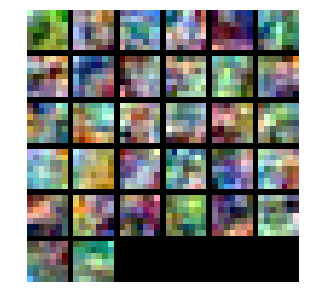

In [7]:
from code_base.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

# Dropout forward pass
In the file `code_base/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes. Refer to slide 19 of lecture 5 for the implementation details. `p` refers to the probability of setting a neuron to zero. We will follow the Caffe convention where we multiply the outputs by `1/(1-p)` during training.

**FOR SUBMISSION:** Submit the corresponding output from your forward dropout for the given input arguments.

Inputs:
- x: Input data. The array in the given csv file is presented in 2D, no reshaping is required
- dropout_param: A dictionary with the following keys:
- p: Dropout parameter. We drop each neuron output with probability p.
- mode: 'test' or 'train'. If the mode is train, then perform dropout; if the mode is test, then just return the input.

Since we cannot control the random seed used for randomly dropping the nodes across all programming languages, there is no unique output for this code. What we will check is whether your output makes sense for the given `p` dropout value.

In [ ]:
x = np.loadtxt('./input_files/dropout_forward_in_x.csv')
# Larger p means more dropout
p = 0.3
out_train, _ = dropout_forward(x, {'mode': 'train', 'p': p})
out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

np.savetxt('./output_files/dropout_forward_out_train.csv', out_train)
np.savetxt('./output_files/dropout_forward_out_test.csv', out_test)

# Dropout backward pass
In the file `code_base/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

**FOR SUBMISSION:** Submit the corresponding output from your backward dropout for the given input arguments.


In [ ]:
dout = np.loadtxt('./input_files/dropout_backward_in_dout.csv')
x = np.loadtxt('./input_files/dropout_backward_in_x.csv')
dropout_param = {'mode': 'train', 'p': 0.8}
out, cache = dropout_forward(x, dropout_param)
dx_train = dropout_backward(dout, cache)
np.savetxt('./output_files/dropout_backward_out_train.csv', dx_train)

dropout_param = {'mode': 'test', 'p': 0.8}
out, cache = dropout_forward(x, dropout_param)
dx_test = dropout_backward(dout, cache)
np.savetxt('./output_files/dropout_backward_out_test.csv', dx_test)

# Train your best three-layer net!
Using the `ThreeLayerConvNet` architecture, tweak the hyperparameters and use what you've learnt to train the best net. For Python users, use the pre-processed (mean-normalized) CIFAR2 data provided here. For users of other languages, you can download the data from the CIFAR10 website: https://www.cs.toronto.edu/~kriz/cifar.html, and ***use just the airplane and bird classes for CIFAR2***.

Keep to the same number of layers, but you are free to use more feature maps, hidden nodes, dropout layers etc. Credits will be given based on your test accuracy and your explanations of your network architecture and training method. Please do not use a GPU, you should be able to train a small net to gain insights. You should not need to wait half a day for the training to complete. The accuracy performance is not a major component of the grade.

Please report the following:
- Training and test accuracy over iterations
- Architecture and training method (eg. optimization scheme, data augmentation): explain your design choices, what has failed and what has worked and why you think they worked/failed
- Try different dropout rates and report their performance

Use only the code you have written and any helper functions provided in this assignment. Do not use external libraries like Tensorflow and Pytorch.

# Final submission instructions
Please submit the following:

1) Your code files in a folder `code_base`

2) Output files to the functions in `output_files`

3) A short report (1-2 pages) in pdf titled `report.pdf`, explaining the logic (expressed using mathematical expressions) behind coding each function and the findings from training your best net

**ASSIGNMENT DEADLINE: 19 OCT 2017 (THU) 11.59PM**

Do not include the CIFAR data files as it takes up substantial memory. Please zip up the following folders under a folder named with your NUSNET ID: eg. `e0123456g.zip' and submit the zipped folder to IVLE/workbin/assignment 2 submission.